# Analysis of Market Returns: Part 2

Here I will continue my analysis the distribution of market returns. From the previous noebook

In [35]:
# Importing the libraries I anticipate using
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import pandas_datareader.data as web
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import datetime
import scipy.stats as stats
import quandl

%matplotlib inline

## More Data

To make the remaining work easier, I am going to design a `Data` class to interact with get get and store the data that I will be using. I will also be introducing currency data from the European Central Bank data on Quandl.

In [2]:
# get my quandl api key, I don't want to show the key so I'll read it in.
f = open('/Users/kennypotts/Desktop/Data/quandl_api_key.txt', 'r')
key = f.read()
key = key.strip()
quandl.ApiConfig.api_key = key

In [3]:
data = quandl.get('ECB/EURUSD')
data.head()

,Value
Date,
1999-01-04,1.1789
1999-01-05,1.1790
1999-01-06,1.1743
1999-01-07,1.1632
1999-01-08,1.1659


In [4]:

class Equity:
    """
    Retrieves and holds data for a single equity
    """
    def __init__(self, symbol, start='1990-01-01', end='today'):
        self.symbol = symbol
        start = start.split('-')
        start = datetime.date(int(start[0]), int(start[1]), int(start[2]))
        
        if end == 'today':
            end = datetime.date.today()
        else:
            end = end.split('-')
            end = datetime.date(int(end[0]), int(end[1]), int(end[2]))
            
        # See if this data is already stored on the disk
        with pd.HDFStore('DataTables.h5') as store:
            try:
                self.pricing = store["/equities/"+symbol+"/pricing"]
                if len(self.actions.index) > 0:
                    self.adj_pricing = store["/equities/"+symbol+"/adj_pricing"]
                self.returns = store["/equities/"+symbol+"/returns"].dropna(how='all')
                self.actions = strore['/equities/'+symbol+'/actions']
                self.start = self.pricing.index[0]
                self.end = self.pricing.index[-1]
            except:
                self.pricing = web.DataReader(self.symbol,'yahoo', start, end)
                store["/equities/"+symbol+"/pricing"] = self.pricing
                self.start = self.pricing.index[0]
                self.end = self.pricing.index[-1]
                self.actions = web.DataReader(self.symbol, 'yahoo-actions', self.start, self.end)
                store['/equities/'+symbol+'/actions'] = self.actions
                if len(self.actions.index) > 0:
                    self.add_adjusted_data()
                    store["/equities/"+symbol+"/adj_pricing"] = self.adj_pricing
                self.returns = np.log(1 + self.pricing['Adj Close'].pct_change())[1:]
                store["/equities/"+symbol+"/returns"] = self.returns
                
    def __repr__(self):
        return "Equity Object: "+self.symbol

        
        
    def add_adjusted_data(self):
        """
        Calculates and adds split adjusted price data as self.adj_pricing.

        Uses yahoo-actions data to determine when and how much stock plits were,
        if they have occured. The initial data are adjusted for the splits,
        with the exception of the Adj Close and Volume which have already been adjusted.
        Adds adjust data as self.adj_pricing
        """
        splits = self.actions[self.actions.action == 'SPLIT']
        self.adj_pricing = self.pricing.copy()
        if len(splits.index) > 0:
            # Find the index and date of the split
            split_idxs = {i:x for i,x in enumerate(self.adj_pricing.index.tolist()) if x in splits.index}
            columns = self.adj_pricing.columns.tolist()

            # adjust for the splits
            for idx, date in split_idxs.items():
                for col in range(len(columns)):
                    if columns[col] != 'Volume' and columns[col] != 'Adj Close':
                        # adjust the prices of the shares
                        self.adj_pricing.iloc[:idx, col] = self.adj_pricing.iloc[:idx, col]*splits.loc[date].value

class Equities:
    """
    Holds Equity Objects and data as attributes.
    """
    def __init__(self):
        with pd.HDFStore('DataTables.h5') as store:
            self.equity_market_caps = store['market_cap_sr']
            self.removed_symbols = store['removed_symbols']
        self.equity_symbols = list(self.equity_market_caps.keys())
        self.ETFs = {'SPY': Equity('SPY'), 'IWM': Equity('IWM'), 'QQQ': Equity('QQQ'),
                     'DIA': Equity('DIA'), 'VTI': Equity('VTI')}
        
        self.equities = {}
        
    def __repr__(self):
        return ("Equities Object, Number of Equities: "+str(len(self.equity_symbols))
                +", Number of ETFs: "+str(len(self.ETFs.keys())))
        
    def get_equity(self, symbol):
        """
        Gets and the Equity object for a specific symbol.
        
        If the data for the Equity object does not exist, the Equity is created if possible.
        If the Equity data cannot be found, will return None, otherwise will return the Equity.
        """
        if symbol in self.equities.keys():
            return equities[symbol]
        elif symbol in self.ETFs.keys():
            return self.ETFs[symbol]
        elif symbol in self.equity_symbols:
            try:
                new_equity = Equity(symbol)
                self.equities[symbol] = new_equity
                return new_equity
            except Exception as e:
                #print('Could not retrieve data for this symbol '+symbol
                #      +", removing symbol and selecting a new one")
                # Remove bad symbol
                self.equity_symbols.remove(symbol)
                self.equity_market_caps = self.equity_market_caps[self.equity_market_caps.index != symbol]
                self.removed_symbols = self.removed_symbols.append(Series([symbol],
                                                                          index=[self.removed_symbols.shape[0]]))
                
                return None
        else:
            print('Data unavailable for ',symbol)
            return None
        
            
    def random_selection(self, size=1, include_ETFs=False):
        """
        Returns a random selection of equity objects of the specified size.
        
        Chosen without replacement. include_ETFs=False by default, set to True to inclue ETFs.
        Will return None if size < 1
        """
        size = int(size)
        symbols = list(np.random.choice(self.equity_symbols, size=size, replace=False))
        if size > 0:
            selections = []
            for i in range(size):
                eq = self.get_equity(symbols[i])
                while eq == None:
                    new_symbol = np.random.choice(self.equity_symbols, size=1, replace=False)[0]
                    if new_symbol not in symbols:
                        symbols[i] = new_symbol
                        eq = self.get_equity(new_symbol)
                selections.append(eq)
            return selections
        return None
                    
        
        
    def __del__(self):
        """
        Stores the updated market_cap_sr Series
        """
        with pd.HDFStore('DataTables.h5') as store:
            store['market_cap_sr'] = self.equity_market_caps
            store['removed_symbols'] = self.removed_symbols
        
        
class Currency_Pair:
    def __init__(self, base, quote):
        self.pair_name = quote+'/'+base
        # Check disk for existing data, if nothing, then download
        with pd.HDFStore('DataTables.h5') as store:
            try:
                self.pricing = store['/Currencies/'+base+'/pricing']
                self.returns = store['/Currencies/'+base+'/returns'].dropna(how='all')
            except:
                self.pricing = quandl.get('ECB/'+quote+base)
                self.returns = np.log(1 + self.pricing.pct_change())[1:]
                store['/Currencies/'+base+'/pricing'] = self.pricing
                store['/Currencies/'+base+'/returns'] = self.returns
        
        self.start = self.pricing.index[0]
        self.end = self.pricing.index[-1]
        
    def __repr__(self):
        return "Currency Pair: "+self.pair_name
               
            
class Currency_Base:
    def __init__(self, base):
        source = 'ECB' # European Central Bank
        self.base = base
        
        if base != 'EUR':
            try:
                self.EUR = Currency_Pair(self.base, 'EUR')
            except:
                pass
        if base != 'USD':
            try:
                self.USD = Currency_Pair(self.base, 'USD')
            except:
                pass
        if base != 'GBP':
            try:
                self.GBP = Currency_Pair(self.base, 'GBP')
            except:
                pass
        if base != 'CAD':
            try:
                self.CAD = Currency_Pair(self.base, 'CAD')
            except:
                pass
        if base != 'AUD':
            try:
                self.AUD = Currency_Pair(self.base, 'AUD')
            except:
                pass
        if base != 'JPY':
            try:
                self.JPY = Currency_Pair(self.base, 'JPY')
            except:
                pass
        if base != 'CHF':
            try:
                self.CHF = Currency_Pair(self.base, 'CHF')
            except:
                pass
        if base != 'NZD':
            try:
                self.NZD = Currency_Pair(self.base, 'NZD')
            except:
                pass
            
    def __repr__(self):
        return "Base Currency: "+self.base
            
class Currencies:
    """
    Holds Currency_Base Objects.
    """
    def __init__(self):
        self.currency_list = ['EUR','USD','GBP','CAD','AUD','JPY','CHF','NZD']
        self.EUR = Currency_Base('EUR')
        self.USD = Currency_Base('USD')
        self.GBP = Currency_Base('GBP')
        self.CAD = Currency_Base('CAD')
        self.AUD = Currency_Base('AUD')
        self.JPY = Currency_Base('JPY')
        self.CHF = Currency_Base('CHF')
        self.NZD = Currency_Base('NZD')
        
    def __repr__(self):
        return "Currencies Object, Cross Rates for "+" ".join(self.currency_list)
    
class Data:
    """
    Data object holds Currencies and Equities objects.
    """
    def __init__(self):
        self.currencies = Currencies()
        self.equities = Equities()
        
    def __repr__(self):
        return "Data Object, holds Equities and Currencies Objects."

Here I will initialize my new data object with which I will interact to get the data I will need. I there is other data that I will require, I will add it to the Data class.

In [5]:
data = Data()

In [42]:
style.use('seaborn-notebook')

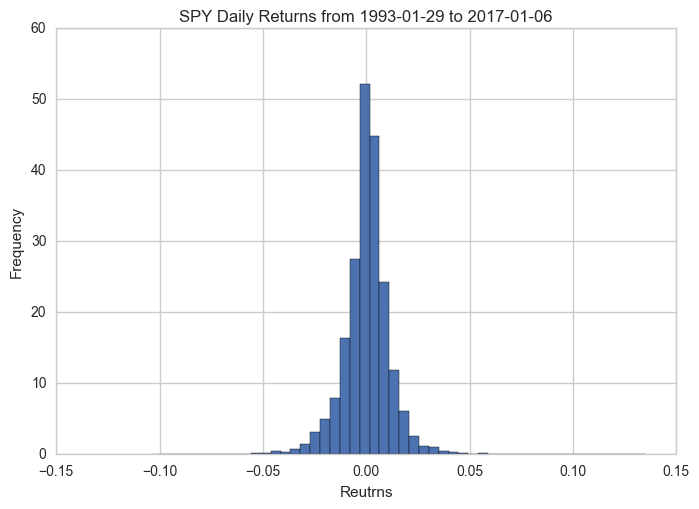

In [21]:
SPY = data.equities.ETFs['SPY']
SPY.returns.hist(bins=50, normed='true')
plt.xlabel('Reutrns')
plt.ylabel('Frequency')
plt.title('{0} Daily Returns from {1} to {2}'.format(SPY.symbol, SPY.start.date(), SPY.end.date()));

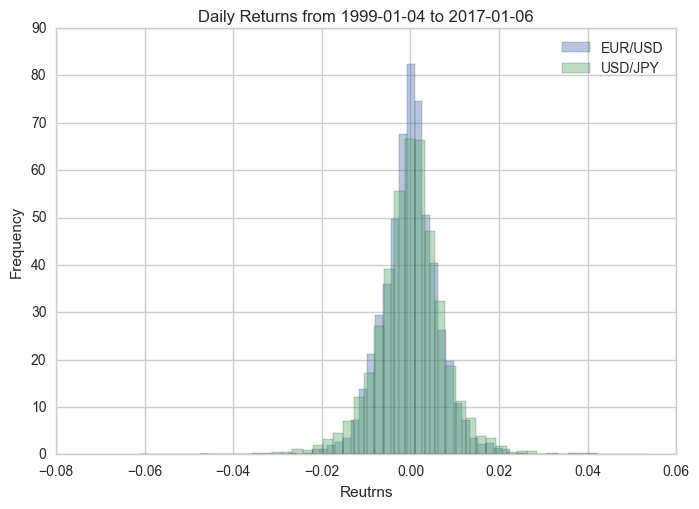

In [43]:
# Plot some currencies
eur_usd = data.currencies.USD.EUR
usd_jpy = data.currencies.JPY.USD
plt.hist(eur_usd.returns.values, bins=50, normed='true', alpha=0.4, label=eur_usd.pair_name)
plt.hist(usd_jpy.returns.values, bins=50, normed='true', alpha=0.4, label=usd_jpy.pair_name)
plt.xlabel('Reutrns')
plt.ylabel('Frequency')
plt.title('Daily Returns from {0} to {1}'.format(eur_usd.start.date(), eur_usd.end.date()))
plt.legend();

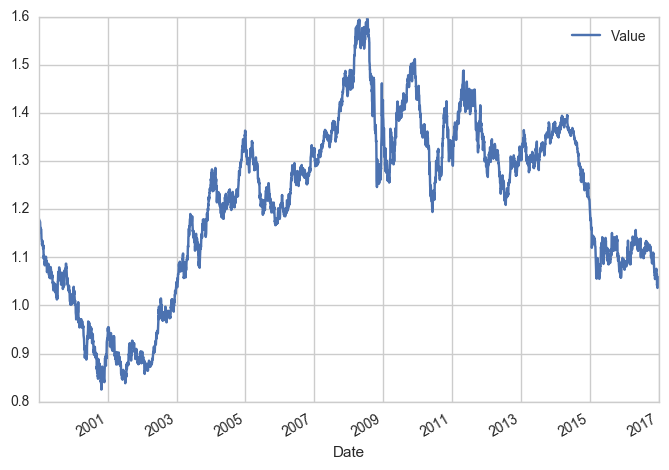

In [47]:
eur_usd.pricing.plot();